### 1. Import all the necessary libraries

In [29]:
import numpy as np
import gym
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
# plot을 위한 설정
%matplotlib inline
plt.style.use('ggplot')

### 2. Simulate the Blackjack environment

In [2]:
env = gym.make('Blackjack-v0')
env.action_space, env.observation_space

(Discrete(2), Tuple(Discrete(32), Discrete(11), Discrete(2)))

* action_space : discrete한 값 2개 (hit or stand)
* observation_space : state를 의미함 (card의 합의 경우의 수 32, 딜러가 보여주는 카드의 경우의 수 11, usable or non-usable ace 2) 

### 3. Define the policy function

In [3]:
# Policy : Takes the current state and check if the score is greater than
# or equal to 20, if yes we return 0(stand) else we return 1(hit).
def sample_policy(observation): # 갖고 있는 카드의 합 (state) 기반의 policy
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

### 4. Define the generate_episode function

In [4]:
# for generating episodes
def generate_episode(policy, env):
    # Initialize the list for storing states, actions, and rewards
    states, actions, rewards = [], [], []
    
    # Initialize the gym environment
    observation = env.reset()
    
    while True:
        # Apppend the states to the states list
        states.append(observation)
        
        # Select an action using our sample_policy function
        # and append the action to actions list
        action = sample_policy(observation)
        actions.append(action)
        
        # Perform the action in the environment according to our
        # sample_policy, move to the next state and receive reward
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        # done : terminate여부
        
        # Break if the state is a terminal state
        if done:
            break
        
    return states, actions, rewards

### 5. Perform First Visit MC Prediction

In [5]:
def first_visit_mc_prediction(policy, env, n_episodes):
    # First, initialize the empty value table as a dictionary for
    # storing the values of each state
    value_table = defaultdict(float)
    N = defaultdict(int)
    
    for _ in range(n_episodes):
        # Next, generate the episode and store the states and rewards
        states, _, rewards = generate_episode(policy, env)
        returns = 0
        
        # Then for each step, store the rewards to a variable R and
        # states to S, and we calculate returns as a sum of rewards
        # 마지막 state부터 (거꾸로)
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            returns += R
            
            # To perform first visit MC, check if the episode is visited
            # for the first time, if yes, we simply take the average of
            # returns and assign the value of the state as an average of
            # returns
            if S not in states[:t]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
        
    return value_table

### 6. Define the plot_blackjack function

In [33]:
# See how our value function is attaining the convergence
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show),
                               len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]
    X, Y = np.meshgrid(player_sum, dealer_show)
    X = np.transpose(X)
    Y = np.transpose(Y)
    ax1.plot_wireframe(Y, X, state_values[:, :, 0])
    ax2.plot_wireframe(Y, X, state_values[:, :, 1])
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state_value')

### 7. Run First Visit MC for Blackjack

In [7]:
value = first_visit_mc_prediction(sample_policy, env, n_episodes=500000)

In [8]:
value

defaultdict(float,
            {(4, 1, False): -0.5646551724137928,
             (4, 2, False): -0.43673469387755104,
             (4, 3, False): -0.5000000000000003,
             (4, 4, False): -0.45535714285714296,
             (4, 5, False): -0.41203703703703715,
             (4, 6, False): -0.4357798165137614,
             (4, 7, False): -0.5021276595744681,
             (4, 8, False): -0.45495495495495486,
             (4, 9, False): -0.46039603960396036,
             (4, 10, False): -0.4783983140147523,
             (5, 1, False): -0.6039823008849556,
             (5, 2, False): -0.5232067510548524,
             (5, 3, False): -0.5043859649122804,
             (5, 4, False): -0.48970251716247143,
             (5, 5, False): -0.4460285132382891,
             (5, 6, False): -0.5050100200400801,
             (5, 7, False): -0.5119825708060994,
             (5, 8, False): -0.39508928571428586,
             (5, 9, False): -0.4539614561027837,
             (5, 10, False): -0.4876712328

* (현재 카드 합, dealer가 보여주는 하나의 카드, usable ace 유무) -> 내 state value
* state value가 크다 -> 이길 가능성이 높다!

### 8. Plot the value function

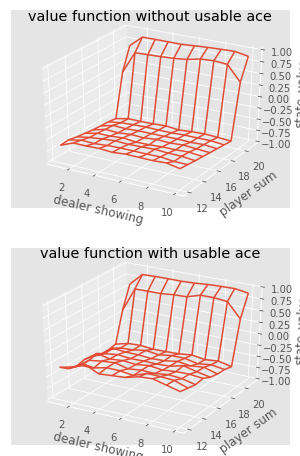

In [34]:
fig, axes = plt.subplots(nrows=2, figsize=(5, 8), subplot_kw=dict(projection="3d"))
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')
plot_blackjack(value, axes[0], axes[1])

* player의 sum이 20, 21에 가까울 때 이길 확률(state value)이 큼